# Multithreaded Cityblock distance matrix function with SciPy and Dask's delayed execution

In this notebook we use the function `scipy.spatial.distance.cdist` to compute the cityblock distance matrix. Althought this function is quite fast, it uses a single thread. In cases like this one, it might be convenient to implement a multithreaded version of the function by parallelicing the execution over chunks of data.

<mark>Question</mark>: This notebook has the chunk-based implementation, but the parallelization is missing. This chunk-based calculation is pointless if there is no the parallelization: Use `dask.delayed` to compute all chunks in parallel and speed up the calculation.

The notebook has no indications of where the modifications need to be done. Just follow the cells and identify what needs to be changed!

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from dask import compute, delayed, visualize

In [2]:
# Create the data
nsamples = 12000
nfeat = 50

rng = np.random.default_rng()
x = 10. * rng.random([nsamples, nfeat])

Let's time the `cdist` function and look the `top` command.

In [3]:
# observe here that the funcion `cdist` used to get the cityblock distance
# is not multithreaded

%timeit cdist(x, x, 'cityblock')

4.89 s ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With the `top` command we see that `cdist` runs in a single thread. In such cases it could be quite simple to write a distributed version of the function. You already know how to this! Let's use `dask.delayed`!

## Dask's async delayed execution
A simple distributed version of `cdist` can be done as the following:
  1. Split the array of vectors into chunks. We can use `np.split(x, num_chunks)`
  2. Compute partial cityblock distance matrices of the complete array with respect to each of the chunks
  3. Concatenate the resulting list into a single cityblock distance matrix.

Note that concatenation is not a fast operation, so probably we will have to continue improving our function.

In [5]:
#  1. Split the array of vectors into chunks. We can use `np.split(x, num_chunks)`
#  2. Compute partial cityblock distance matrices of the complete array with respect to each of the chunks

import dask

chunks = 12  # define the number of operations to be performed asynchronously
             # we choose one chunk per physical CPU (12 phyical CPUs in Pz Daint `gpu` partition)

partial_distances = [dask.delayed(cdist)(x, xi, 'cityblock')
                     for xi in np.split(x, chunks)]

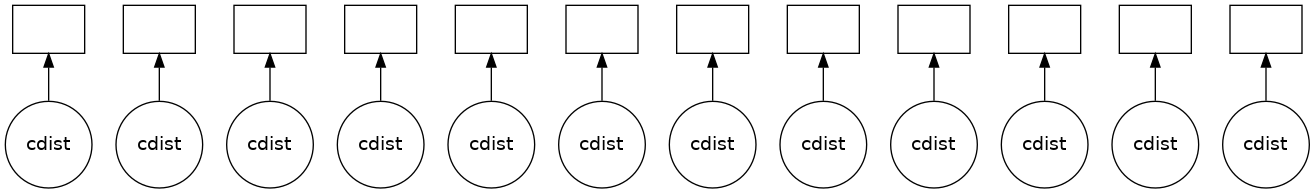

In [6]:
# visualize the computational graph until this point
visualize(partial_distances)

In [8]:
cbdm = dask.delayed(np.concatenate)(partial_distances, axis=1)

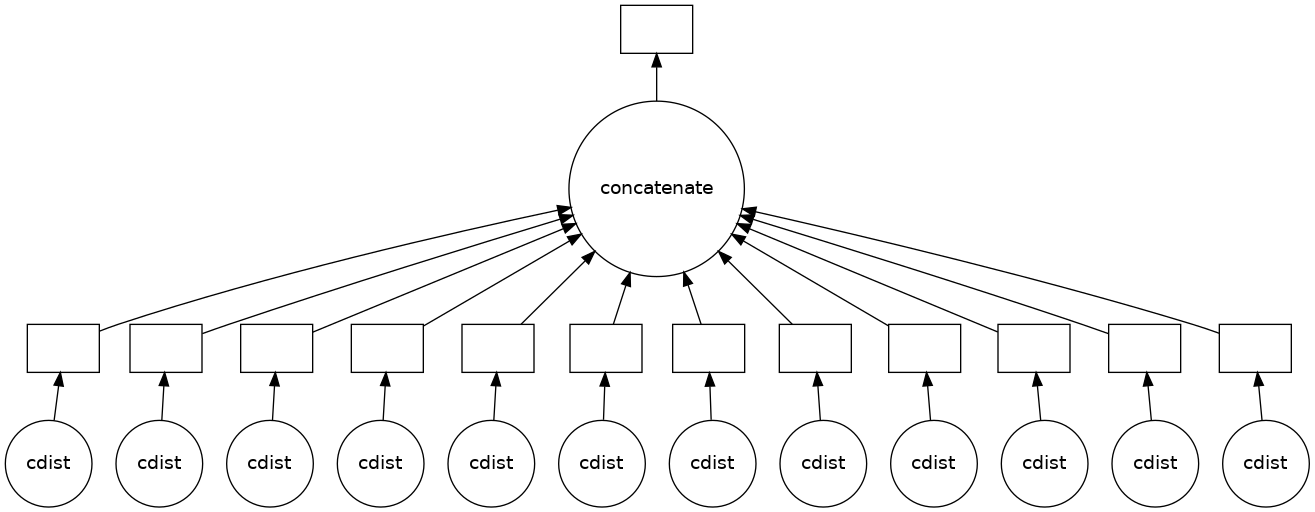

In [9]:
# visualize the computational graph
cbdm.visualize()

At this point, you should have the computational graph already defined. Let's run and time the compute step. We may go a shell and run the command `top`. Now you should see that the computation is executed in parallel resulting in a shorter execution time.

In [11]:
#time and run the computational graph
%timeit cbdm.compute()


1.09 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Delayed('concatenate-4b92bba0-3bb5-45ac-a487-999d6ae0c24f')

In [13]:
# check that the resulting matrices are the same
np.abs(cbdm.compute() - cdist(x, x, 'cityblock')).max()

0.0

A problem with this solution, as mentioned above, is that `np.concatenate` is not  a fast operation.
Let's check how much time it takes without the concatenation part:

In [15]:
# time and run the computational graph without the concatenate part
%timeit dask.compute(partial_distances, scheduler='threads')

503 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's implement the whole thing as a single function:

In [ ]:
# Implementing the whole thing as a single function
def cityblock_dask(x, y, chunks):
    """Implementation using array concatenation"""
    

In [ ]:
# check that the resulting matrices are the same
# print(np.abs(cityblock_dask(x, x, chunks) - cdist(x, x, 'cityblock')).max())

<mark>Question</mark>: Why is relevant for this implementation the fact that `scipy.spatial.distance.cdist` is not multithreaded?